# Downloading and Processing Weather Data
In order to properly download the weather data, we need to know which of the ERA5 grid cells they fall into. In order to do this, I will create a modified version of the locations dataset, corresponding each voltage station to a netCDF grid cell. The lat and lon of which represents the center of its respective grid cell. Through experimentation, we know that these lie on the 0.1 marks of lat and lon, meaning the grid cells all span from +- 0.05 of that center, for example from lat 30.15 to 30.25, and lon 76.25 to 76.35.

In [1]:
import netCDF4 as nc
import pandas as pd
from datetime import datetime, timedelta
import os
from tqdm import tqdm
import numpy as np
import cdsapi
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
locations_path = "../ESMI_India_538_locations.csv"
locations = pd.read_csv(locations_path, dtype={"ESMI_ID" : str, "station_id" : int}, usecols=["station_id", "ESMI_ID", "Location name", "District", "State", "Lat", "Lon"])

In [3]:
uniform_dir = "../india_processing/india_uniform"

# For every station that we have collected the uniform data for, we list down the minimum and maximum time for that station, giving it a month on either side
for file in tqdm(os.listdir(uniform_dir)):
    station_id = int(file.split("_")[1].split(".")[0])
    station_df = pd.read_csv(os.path.join(uniform_dir, file), header=0, index_col=False, parse_dates=['time'])
    station_min = station_df['time'].min()
    station_max = station_df['time'].max()
    
    if station_min.month == 1:
        station_min = datetime(station_min.year - 1, 12, 1)
    else:
        station_min = datetime(station_min.year, station_min.month - 1, 1)

    if station_max.month == 12:
        station_max = datetime(station_max.year + 1, 1, 1)
    else:
        station_max = datetime(station_max.year, station_max.month + 1, 1)

    locations.loc[locations['station_id'] == station_id, 'era_min_time'] = station_min
    locations.loc[locations['station_id'] == station_id, 'era_max_time'] = station_max

  0%|          | 0/536 [00:00<?, ?it/s]

100%|██████████| 536/536 [08:40<00:00,  1.03it/s]


We drop all those locations that we didn't create uniform data for.

In [4]:
locations = locations.dropna(subset=['era_min_time', 'era_max_time'])

Then for each station, we consider which grid cell we need to download. We'll do this simply by calculating which grid center (multiple of 0.1) it is closest to in terms of both longitude and latitude.

In [5]:
for station_id in tqdm(locations['station_id']):
    lat = locations.loc[locations['station_id'] == station_id, 'Lat']
    lon = locations.loc[locations['station_id'] == station_id, 'Lon']

    era_lat = np.round(lat * 10) / 10
    era_lon = np.round(lon * 10) / 10

    locations.loc[locations['station_id'] == station_id, 'era_lat'] = era_lat
    locations.loc[locations['station_id'] == station_id, 'era_lon'] = era_lon

100%|██████████| 536/536 [00:00<00:00, 785.92it/s]


Below we can determine that some of the stations share the same ERA5 grid cell. Therefore, we'll download the ERA5 data and label it by its actual grid cell, that way we can reuse as needed.

In [6]:
weather = set()
for i in range(len(locations)):
    weather.add((locations.iloc[i]['era_lat'], locations.iloc[i]['era_lon']))

print(len(weather))

308


In [7]:
locations.to_csv("../era5_locations.csv", index=False)

I go on to classify a set of geographic locations over which to download the data, because instead of pulling all of the data points for the entirety of India each time, I can pull a smaller geographic subset that encompasses multiple stations but also avoid the long queueing delays for the CDS requests.

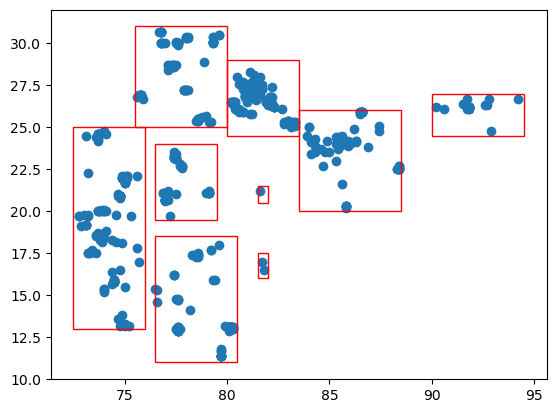

In [3]:
locations = pd.read_csv("../era5_locations.csv", index_col=False, parse_dates=['era_min_time', 'era_max_time'])
x = locations['era_lon']
y = locations['era_lat']
fig, ax = plt.subplots()
plt.scatter(x, y)

regions = [[26, 83.5, 20, 88.5], [27, 90, 24.5, 94.5], [29, 80, 24.5, 83.5], [31, 75.5, 25, 80], [25, 72.5, 13, 76], [24, 76.5, 19.5, 79.5], [18.5, 76.5, 11, 80.5], [17.5, 81.5, 16, 82], [21.5, 81.5, 20.5, 82]] # North, West, South, East
for region in regions:
    ax.add_patch(patches.Rectangle((region[1], region[2]), region[3] - region[1], region[0] - region[2], edgecolor='r', facecolor='none'))

In [8]:
region_time_bounds = []
for region in regions:
    locations_in_region = locations[locations['era_lat'].between(region[2], region[0]) & locations['era_lon'].between(region[1], region[3])]
    region_min_time = locations_in_region['era_min_time'].min()
    region_max_time = locations_in_region['era_max_time'].max()
    
    region_time_bounds.append((region_min_time, region_max_time))

We can now proceed to actual perform the downloading of the data, looping through each station and time, skipping the ones that have already been downloaded.

In [9]:
weather_dir = 'E:\Georgia Institute of Technology\He, Yiyi - 01_data\EAR5\\final_verification\ERA5'

if os.path.exists(weather_dir) == False:
    os.makedirs(weather_dir)

c = cdsapi.Client()

for index, (time_range, region) in enumerate(zip(region_time_bounds, regions)):
    min_time, max_time = time_range

    year = min_time.year
    month = min_time.month
    curr_time = datetime(year, month, 1)

    while curr_time <= max_time:
        year_s = str(curr_time.year)
        month_s = str(curr_time.month).zfill(2)

        filename = f'ERA5_{year_s}_{month_s}_region_{index}.nc'
        if os.path.exists(os.path.join(weather_dir, filename)) == False:
            r = c.retrieve(
            'reanalysis-era5-land', {
                    'variable'    : ['2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind', 'total_precipitation'],
                    'year'        : year_s,
                    'month'       : month_s,
                    'day': [
                        '01', '02', '03',
                        '04', '05', '06',
                        '07', '08', '09',
                        '10', '11', '12',
                        '13', '14', '15',
                        '16', '17', '18',
                        '19', '20', '21',
                        '22', '23', '24',
                        '25', '26', '27',
                        '28', '29', '30',
                        '31',
                        ],
                    'time': [
                        '00:00', '01:00', '02:00',
                        '03:00', '04:00', '05:00',
                        '06:00', '07:00', '08:00',
                        '09:00', '10:00', '11:00',
                        '12:00', '13:00', '14:00',
                        '15:00', '16:00', '17:00',
                        '18:00', '19:00', '20:00',
                        '21:00', '22:00', '23:00',
                    ],
                    'area'          : region,
                    'format'      : 'netcdf'
            })

            r.download(os.path.join(weather_dir, filename))
        else:
            print(f'File {filename} already exists')

        if curr_time.month == 12:
            curr_time = datetime(curr_time.year + 1, 1, 1)
        else:
            curr_time = datetime(curr_time.year, curr_time.month + 1, 1)

File ERA5_2014_10_region_0.nc already exists
File ERA5_2014_11_region_0.nc already exists
File ERA5_2014_12_region_0.nc already exists
File ERA5_2015_01_region_0.nc already exists
File ERA5_2015_02_region_0.nc already exists
File ERA5_2015_03_region_0.nc already exists
File ERA5_2015_04_region_0.nc already exists


2024-07-17 09:14:33,822 INFO Welcome to the CDS
2024-07-17 09:14:33,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2024-07-17 09:14:34,054 INFO Request is completed
2024-07-17 09:14:34,055 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data0/adaptor.mars.internal-1721186560.2992835-30810-17-5a0f33df-c596-46ec-b9b1-e75c838802b2.nc to E:\Georgia Institute of Technology\He, Yiyi - 01_data\EAR5\final_verification\ERA5\ERA5_2015_05_region_0.nc (17.7M)
2024-07-17 09:14:42,068 INFO Download rate 2.2M/s   
2024-07-17 09:14:42,189 INFO Welcome to the CDS
2024-07-17 09:14:42,190 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2024-07-17 09:14:42,386 INFO Request is queued
2024-07-17 09:14:45,147 INFO Request is running
2024-07-17 09:27:03,856 INFO Request is completed
2024-07-17 09:27:03,988 INFO Downloading https://download-0014-clone.copernicus-clima

In [104]:
weather_dir = 'E:\Georgia Institute of Technology\He, Yiyi - 01_data\EAR5\\final_verification\ERA5'
weather_output_dir = 'E:\Georgia Institute of Technology\He, Yiyi - 01_data\EAR5\\final_verification\ERA5_lat_lon'

In [40]:
# Sort all of the raw netcdf4 files into the regions so we can avoid opening and closing the relevant grid cell files multiple times
regions = {}
for file in os.listdir(weather_dir):
    region = int(file.split("_")[-1].split(".")[0])
    if region not in regions:
        regions[region] = [file]
    else:
        regions[region].append(file)

In [101]:
# For each of the files in a given region, filter out all of locations that are in that region, and then write the relevant data to a dataframe, writing to a csv when the region is complete
grid_cells = {}
for region_id, files in regions.items():
    nc_file = nc.Dataset(os.path.join(weather_dir, files[0]), 'r')

    lon = nc_file.variables['longitude'][:]
    lat = nc_file.variables['latitude'][:]

    lon_min = lon.min()
    lon_max = lon.max()

    lat_min = lat.min()
    lat_max = lat.max()

    locations_in_region = locations[locations['era_lat'].between(lat_min, lat_max) & locations['era_lon'].between(lon_min, lon_max)]
    locations_in_region.reset_index(drop=True, inplace=True)

    for file in files:
        nc_file = nc.Dataset(os.path.join(weather_dir, file), 'r')

        lon = nc_file.variables['longitude'][:]
        lat = nc_file.variables['latitude'][:]
        time = np.ma.getdata(nc_file.variables['time'][:])
        t2m = nc_file.variables['t2m'][:]
        tp = nc_file.variables['tp'][:]
        u10 = nc_file.variables['u10'][:]
        v10 = nc_file.variables['v10'][:]
        time = nc_file.variables['time'][:]

        for i in range(len(locations_in_region)):
            lat_s = locations_in_region.iloc[i]['era_lat']
            lon_s = locations_in_region.iloc[i]['era_lon']
            era5_station = f"{lat_s}_{lon_s}"

            base = datetime(1900, 1, 1)
            time_s = np.vectorize(lambda x: base + timedelta(hours=int(x)))(time)
            t2m_s = np.squeeze(t2m[:, lat == lat_s, lon == lon_s])
            tp_s = np.squeeze(tp[:, lat == lat_s, lon == lon_s])
            u10_s = np.squeeze(u10[:, lat == lat_s, lon == lon_s])
            v10_s = np.squeeze(v10[:, lat == lat_s, lon == lon_s])

            if era5_station not in grid_cells:
                grid_cells[era5_station] = [pd.DataFrame({'datetime' : time_s, 't2m' : t2m_s, 'tp' : tp_s, 'u10' : u10_s, 'v10' : v10_s})]
            else:
                grid_cells[era5_station].append(pd.DataFrame({'datetime' : time_s, 't2m' : t2m_s, 'tp' : tp_s, 'u10' : u10_s, 'v10' : v10_s}))

In [105]:
# For grid cells that are covered by multiple regions, we'll just double append, then remove by the duplicates and sort by time at the very end after all the regions are done
for era5_station, dataframes in grid_cells.items():
    combined = pd.concat(dataframes, axis=0)
    combined.reset_index(drop=True, inplace=True)
    combined = combined.rename(columns={'time': 'datetime'})
    combined.sort_values(by='datetime', inplace=True)
    combined.drop_duplicates(subset='datetime', keep='first', inplace=True)
    combined.to_csv(os.path.join(weather_output_dir, f"station_{era5_station}.csv"), index=False)

## Previous ERA5 Verification
To verify against the previous extraction of the ERA5 data, I will use the locations table to correlate the old station ids against the new lat lon station files, merge on the time column and verify if they are the same.

In [107]:
previous_weather_dir = 'E:\Georgia Institute of Technology\He, Yiyi - 01_data\Final_version\weather_india'

In [119]:
for file in os.listdir(previous_weather_dir):
    if file.endswith('.csv'):
        station_id = int(file.split("_")[-2].split(".")[0])
        previous_df = pd.read_csv(os.path.join(previous_weather_dir, file), header=0, index_col=False, parse_dates=['datetime'])

        location = locations[locations['station_id'] == station_id]
        lat_lon_s = f"{location['era_lat'].values[0]}_{location['era_lon'].values[0]}"
        current_df = pd.read_csv(os.path.join(weather_output_dir, f'station_{lat_lon_s}.csv'), header=0, index_col=False, parse_dates=['datetime'])
        
        matched_df = previous_df.merge(current_df, on='datetime', how='left', suffixes=('_prev', '_curr'))
        different = (matched_df['t2m_curr'] == matched_df['t2m_prev']).value_counts().get(False, 0)

        if different > 0:
            print(f"Station {station_id} has {different} different values")
        else:
            print(f"Station {station_id} is the same")

Station 1 has 38017 different values
Station 2 has 38017 different values
Station 4 has 38017 different values
Station 5 has 38017 different values
Station 6 has 38017 different values
Station 7 has 8760 different values
Station 8 has 38017 different values
Station 9 has 38017 different values
Station 10 has 38017 different values
Station 11 has 38017 different values
Station 12 has 38017 different values
Station 13 has 38017 different values
Station 14 has 38017 different values
Station 15 has 38017 different values
Station 16 has 38017 different values
Station 17 has 38017 different values
Station 18 has 38017 different values
Station 20 has 38017 different values
Station 21 has 38017 different values
Station 22 has 38017 different values
Station 23 has 38017 different values
Station 24 has 38017 different values
Station 27 has 38017 different values
Station 28 has 38017 different values
Station 29 has 38017 different values
Station 30 has 38017 different values
Station 31 has 38017 

IndexError: index 0 is out of bounds for axis 0 with size 0